# SignalDB

The SignalDB database contains all of the meta-data for the raw SETI data availaible in the SETI@IBMCloud project.

You can use this data to visualize the locations of stars the SETI Institute has observed, select and sort through to find data that interests you, and ultimately use these meta-data to download the appropriate raw data file for analysis, feature extraction and machine learning. 

This database is available from the `setigopublic` server and can be downloaded with `curl`, unzipped and read into a Spark Dataframe in the usual way.

In [2]:
!curl https://setigopublic.mybluemix.net/v1/aca/meta/all > signaldb.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M    0 18.8M    0     0  4430k      0 --:--:--  0:00:04 --:--:-- 4777k


In [3]:
!gunzip signaldb.csv.gz

In [1]:
!ls -alh signaldb.csv

-rw-r----- 1 sfa7-9e7464df3e1117-5edfd8a0d95d users 122M May 24 16:31 signaldb.csv


In [2]:
#Spark 2.0 and higher
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema','true')\
  .load('signaldb.csv')
df.take(5)


[Row(UNIQUEID=u'ldn1622_1500_168_3011_19_103758', TIME=datetime.datetime(2013, 3, 2, 6, 3, 29), ACTTYP=u'pointantswait', TGTID=2800031, CATALOG=u'ldn1622grid', RA2000HR=5.872, DEC2000DEG=1.087, POWER=401.0, SNR=None, FREQMHZ=1499.79070556, DRIFTHZS=-1.145, WIDHZ=2.778, POL=u'left', SIGTYP=u'CwP', PPERIODS=None, NPUL=0, INTTIMES=94.0, TSCPAZDEG=233.671, TSCPELDEG=36.754, BEAMNO=3, SIGCLASS=u'Cand', SIGREASON=u'PsPwrT', CANDREASON=u'SnMulBm', CONTAINER=u'setiCompAmp', OBJECTNAME=u'2013-03-02/act168/2013-03-02_06-03-45_UTC.act168.dx3011.id-19.R.archive-compamp'),
 Row(UNIQUEID=u'ldn1622_1500_168_3002_4_103698', TIME=datetime.datetime(2013, 3, 2, 6, 3, 29), ACTTYP=u'pointantswait', TGTID=2800031, CATALOG=u'ldn1622grid', RA2000HR=5.872, DEC2000DEG=1.087, POWER=414.0, SNR=None, FREQMHZ=1491.86280556, DRIFTHZS=-0.121, WIDHZ=2.778, POL=u'right', SIGTYP=u'CwP', PPERIODS=None, NPUL=0, INTTIMES=94.0, TSCPAZDEG=233.671, TSCPELDEG=36.754, BEAMNO=3, SIGCLASS=u'Cand', SIGREASON=u'PsPwrT', CANDREASON=

In [3]:
df.cache()

DataFrame[UNIQUEID: string, TIME: timestamp, ACTTYP: string, TGTID: int, CATALOG: string, RA2000HR: double, DEC2000DEG: double, POWER: double, SNR: double, FREQMHZ: double, DRIFTHZS: double, WIDHZ: double, POL: string, SIGTYP: string, PPERIODS: double, NPUL: int, INTTIMES: double, TSCPAZDEG: double, TSCPELDEG: double, BEAMNO: int, SIGCLASS: string, SIGREASON: string, CANDREASON: string, CONTAINER: string, OBJECTNAME: string]

# Visualization with Pixiedust

[Pixiedust is a tool built for Spark](https://github.com/ibm-cds-labs/pixiedust) that assists developers in visualization, 
loading and saving data, and package management that allows one to install and use Scala/Java Spark packages from within the Pyspark environment. 


In [14]:
#!pip install --user --upgrade pixiedust

    100% |████████████████████████████████| 112kB 2.4MB/s 
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sfa7-9e7464df3e1117-5edfd8a0d95d/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/sfa7-9e7464df3e1117-5edfd8a0d95d/.local/lib/python2.7/site-packages (from pixiedust)
  Running setup.py bdist_wheel for pixiedust ... - \ | / done
  Stored in directory: /gpfs/fs01/user/sfa7-9e7464df3e1117-5edfd8a0d95d/.cache/pip/wheels/64/88/d8/dab16cc6385c872294f763afd88cb35bc3a6e679506b1e5231
Successfully built pixiedust
  Found existing installation: pixiedust 1.0.4
    Uninstalling pixiedust-1.0.4:
      Successfully uninstalled pixiedust-1.0.4


In [4]:
import pixiedust

Pixiedust database opened successfully


In [7]:
df.createOrReplaceTempView("signaldb")

We'll use pixiedust to display the RA/DEC location of the data. First, we need to remove the 'spacecraft' data

In [9]:
df = spark.sql("select * from signaldb where catalog!='spacecraft'")


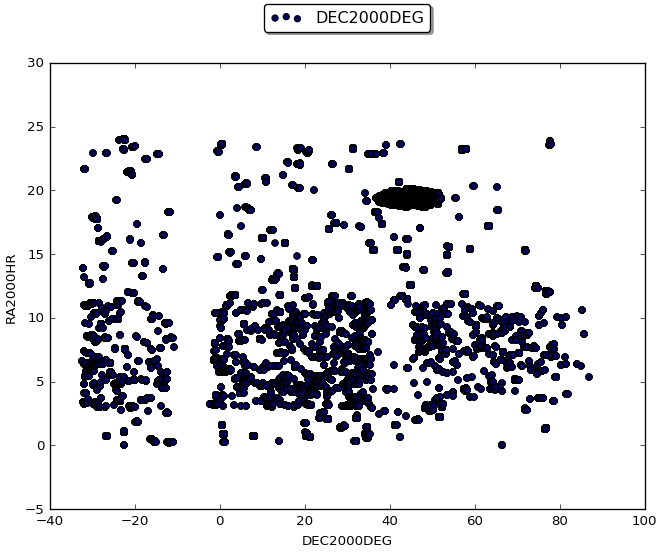

In [10]:
display(df)

# SparkSQL to select a subset of SignalDB 

The following SQL selects data for a particular star. This statement returns the raw data Object Store container and objectname for all data for that star in the data set.

## Interesting Target

Kepler 1229b, found here http://phl.upr.edu/projects/habitable-exoplanets-catalog, is a very intersting target. This candidate has an Earth similarity index (ESI) of 0.73 (Earth = 1.0, Mars = 0.64, Jupiter = 0.12) and is 770 light-years away. It is the 5th highest-ranked planet by ESI. According to the catalog, it's RA/DEC coordinates are 19.832 and 46.997, respectively.

In [11]:
df2 = spark.sql("select * from signaldb where RA2000hr == 19.832 and dec2000deg == 46.997")


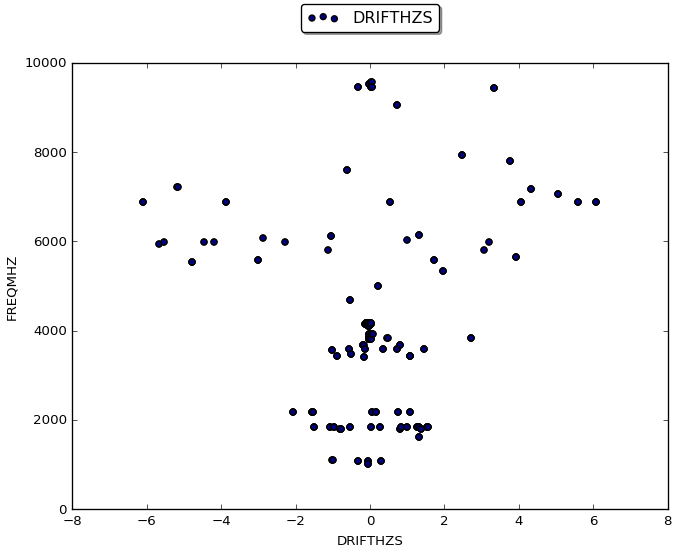

In [12]:
display(df2)

# Read the Raw Data


The raw data are located on IBM Object storage in containers. The `container` and `objectname` values tell you specifically where to look. See the [subsequent notebooks for tutorials](https://github.com/ibm-cds-labs/seti_at_ibm#introduction-notebooks) on reading the raw data files, creating spectrograms and extracting features. 


In [13]:
df2_loc = spark.sql("select container, objectname from signaldb where RA2000hr == 19.832 and dec2000deg == 46.997")
raw_loc = df2_loc.collect()

In [14]:
raw_loc[:5]

[Row(container=u'setiCompAmp', objectname=u'2014-10-20/act37977/2014-10-20_02-12-21_UTC.act37977.dx2009.id-1.R.archive-compamp'),
 Row(container=u'setiCompAmp', objectname=u'2014-10-20/act37977/2014-10-20_02-12-21_UTC.act37977.dx2009.id-1.L.archive-compamp'),
 Row(container=u'setiCompAmp', objectname=u'2014-10-20/act37977/2014-10-20_02-12-21_UTC.act37977.dx2009.id-1.R.archive-compamp'),
 Row(container=u'setiCompAmp', objectname=u'2014-10-20/act37977/2014-10-20_02-12-21_UTC.act37977.dx2009.id-1.L.archive-compamp'),
 Row(container=u'setiCompAmp', objectname=u'2013-08-03/act6312/2013-08-03_07-34-07_UTC.act6312.dx2021.id-0.R.archive-compamp')]